In [132]:
import json
import os

import contextily as ctx
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point, LineString
from tqdm import tqdm

tqdm.pandas()

# Travel distribution

## Load excel file

In [2]:
kbr_data_path = '../../data/raw/KBR/'
kbr_dir_path = '1_Ankiety_w_gospodarstwach_domowych/'
kbr_file_path = 'Etap_V_1_1_Ankiety_w_gospodarstwach_domowych_Wroclaw.xlsx'
excel_sheet = 'Wrocław_ankiety+podróże'

df = pd.read_excel(os.path.join(kbr_data_path, kbr_dir_path, kbr_file_path), excel_sheet, header=[0,1], engine='openpyxl')

In [3]:
df.head()

Lp          IDENTYFIKACJA ANKIETY               \
    Lp ID_LOS (numer kwestionariusza) Nr ankietera   
0  1.0                  LOS_67-67-306          NaN   
1  2.0                  LOS_67-67-306          NaN   
2  3.0                  LOS_67-67-109          NaN   
3  4.0                  LOS_67-67-109          NaN   
4  5.0                  LOS_67-67-401          NaN   

                                                                        \
  Data wypełnienia kwestionariusza Godzina wypełnienia kwestionariusza   
0                       2018-04-25                               17:20   
1                       2018-04-25                               17:20   
2                       2018-04-26                               17:05   
3                       2018-04-26                               17:05   
4                       2018-04-26                               17:10   

                             \
  Nr rejonu komunikacyjnego   
0                      67.0   
1                      67.0   
2                      67.0   
3                      67.0   
4                      67.0   

                           PREFERENCJE DOT. MOBILNOŚCI MIEJSKIEJ  \
  Wprowadzenie opłat za wjazd do centrum dla wszystkich pojazdów   
0                             całkowicie się zgadzam               
1                             całkowicie się zgadzam               
2                                 raczej się zgadzam               
3                                 raczej się zgadzam               
4                             całkowicie się zgadzam               

                                                                                                                                                                     \
  Dopuszczenie dojazdu do centrum dla pojazdów, które nie zanieczyszczają środowiska (np. pojazdy elektryczne, hybrydowe lub spełniające najwyższe normy spalania)    
0                             całkowicie się zgadzam                                                                                                                  
1                             całkowicie się zgadzam                                                                                                                  
2                             całkowicie się zgadzam                                                                                                                  
3                             całkowicie się zgadzam                                                                                                                  
4                             całkowicie się zgadzam                                                                                                                  

                                                                                                                                                                                      \
  Jaka jest Pana/Pani opinia na temat rozwiązań wspierających kursowanie tramwajów i autobusów, takich jak priorytet przejazdu na skrzyżowaniach oraz wydzielone pasy na jezdniach?    
0                             całkowicie się zgadzam                                                                                                                                   
1                             całkowicie się zgadzam                                                                                                                                   
2                             całkowicie się zgadzam                                                                                                                                   
3                             całkowicie się zgadzam                                                                                                                                   
4                             całkowicie się zgadzam                                                                                     

In [4]:
# Combining header rows of a multiIndex DataFrame
df.columns = [f'{i}_{j}' for i, j in df.columns]
df = df.iloc[0:14241]

In [5]:
if df.shape[1] == len(set(list(df.columns))):
    print('All column names are unique.')
else:
    print('All column names are NOT unique.')

All column names are unique.


## Dataframe filtering by selected columns + mapping age_bracket and sex values

In [6]:
chosen_cols = [
    'IDENTYFIKACJA ANKIETY_ID_LOS (numer kwestionariusza)',
    'DANE O RESPONDENCIE_Przedział wiekowy',
    'DANE O RESPONDENCIE_Płeć',
    'OPIS PODRÓŻY "ŹRÓDŁO"_Nr rejonu',
    'OPIS PODRÓŻY "CEL"_Nr rejonu'
]

df_filtered = df[chosen_cols]
df_filtered.columns = ['id', 'age_bracket', 'sex', 'source_region', 'destination_region']

age_bracket_map_dict = {
    '6-15 (dzieci)': '6-15',
    '16-19 (młodzież)': '16-19',
    '20-24 (wiek studencki)': '20-24',
    '25-44 (młodsi pracownicy)': '25-44',
    '45-60 (starsi pracownicy kobiety)': '45-60',  # '45-60(K)',
    '45-65 (starsi pracownicy mężczyźni)': '45-65',  # '45-65(M)',
    '61 i więcej (emeryci kobiety)': '61-x',  # '61-(K)',
    '66 i więcej (emeryci mężczyźni)': '66-x'  # '66-(M)'
}
df_filtered.replace({'age_bracket': age_bracket_map_dict}, inplace=True)

sex_map_dict = {
    'Kobieta': 'K',
    'Mężczyzna': 'M'
}
df_filtered.replace({'sex': sex_map_dict}, inplace=True)

df_filtered['age_sex_comb'] = df_filtered['age_bracket'] + '_' + df_filtered['sex']

In [10]:
df_filtered.groupby(['age_sex_comb']).size()

age_sex_comb
16-19_K     214
16-19_M     287
20-24_K     690
20-24_M     631
25-44_K    2409
25-44_M    2190
45-60_K    1577
45-65_M    1779
6-15_K      737
6-15_M      573
61-x_K     2035
66-x_M     1119
dtype: int64

## Add boolean travel column

In [11]:
df_filtered.head()

,id,age_bracket,sex,source_region,destination_region,age_sex_comb
0,LOS_67-67-306,61-x,K,67.0,68.0,61-x_K
1,LOS_67-67-306,61-x,K,68.0,67.0,61-x_K
2,LOS_67-67-109,20-24,K,NaN,NaN,20-24_K
3,LOS_67-67-109,20-24,M,NaN,NaN,20-24_M
4,LOS_67-67-401,61-x,K,NaN,NaN,61-x_K


In [12]:
def add_travel_col(row):
    row['travel'] = True if row['source_region'] >= 0 else False

    return row

df_filtered = df_filtered.fillna(-1)
df_filtered = df_filtered.apply(add_travel_col, axis=1)

In [13]:
df_filtered.head()

,id,age_bracket,sex,source_region,destination_region,age_sex_comb,travel
0,LOS_67-67-306,61-x,K,67.0,68.0,61-x_K,True
1,LOS_67-67-306,61-x,K,68.0,67.0,61-x_K,True
2,LOS_67-67-109,20-24,K,-1.0,-1.0,20-24_K,False
3,LOS_67-67-109,20-24,M,-1.0,-1.0,20-24_M,False
4,LOS_67-67-401,61-x,K,-1.0,-1.0,61-x_K,False


## Probability distribution of travel with a distinction between age range and gender

In [14]:
df_grouped = df_filtered.groupby(['age_sex_comb', 'travel'])['id'].count().reset_index(name='count')

df_grouped.head(24)

,age_sex_comb,travel,count
0,16-19_K,False,32
1,16-19_K,True,182
2,16-19_M,False,21
3,16-19_M,True,266
4,20-24_K,False,100
5,20-24_K,True,590
6,20-24_M,False,100
7,20-24_M,True,531
8,25-44_K,False,410
9,25-44_K,True,1999


In [15]:
travel_distr = {}

for age_sex_comb in df_grouped['age_sex_comb']:
    asc_true = int(df_grouped[
        (df_grouped['travel'] == True) & 
        (df_grouped['age_sex_comb'] == age_sex_comb)
    ]['count'])
    asc_false = int(df_grouped[
        (df_grouped['travel'] == False) & 
        (df_grouped['age_sex_comb'] == age_sex_comb)
    ]['count'])

    travel_distr[age_sex_comb] = {
        'True': asc_true,
        'False': asc_false
    }

travel_distr

{'16-19_K': {'True': 182, 'False': 32},
 '16-19_M': {'True': 266, 'False': 21},
 '20-24_K': {'True': 590, 'False': 100},
 '20-24_M': {'True': 531, 'False': 100},
 '25-44_K': {'True': 1999, 'False': 410},
 '25-44_M': {'True': 1822, 'False': 368},
 '45-60_K': {'True': 1326, 'False': 251},
 '45-65_M': {'True': 1467, 'False': 312},
 '6-15_K': {'True': 610, 'False': 127},
 '6-15_M': {'True': 476, 'False': 97},
 '61-x_K': {'True': 1530, 'False': 505},
 '66-x_M': {'True': 809, 'False': 310}}

# Travel length distribution

## Load region shape files

In [16]:
kbr_data_path = '../../data/raw/KBR/'
kbr_dir_path = 'Etap_I_II_Wyznaczenie_obszaru_badan_liczby_mieszkancow_i_miejsc_pracy_na_podstawie_kart_SIM/Pliki_GIS_Wyznaczenie_obszaru_badan/2_Podzial_na_rejony/'
kbr_file_path = 'EtapII-REJONY_wroclaw.shp'

regions_file = os.path.join(kbr_data_path, kbr_dir_path, kbr_file_path)
regions = gpd.read_file(regions_file)
regions = regions.to_crs(epsg=3857)

kbr_file_path = 'EtapII-REJONY_wroclaw_centroidy.shp'

regions_centroids_file = os.path.join(kbr_data_path, kbr_dir_path, kbr_file_path)
regions_centroids = gpd.read_file(regions_centroids_file)
regions_centroids = regions_centroids.to_crs(epsg=3857)

In [17]:
regions.head()

,NUMBER,NAME,ZST_0_5,ZST_6_15,ZST_16_19,ZST_20_24,ZST_25_44,ZST_45_WE,ZST_WE_I_W,ZST_SUMA,...,ZCZ_25_44,ZCZ_45_WE,ZCZ_WE_I_W,ZCZ_SUMA,GUS_MI,GUS_MI_6_,BD_A_MI_6_,REGON_ZI,BD_A_ZI,geometry
0,22,Komandorska/Swobodna,111.0,200.0,68.0,82.0,670.0,606.0,1412.0,3149.0,...,32.0,11.0,3.0,64.0,3213,3102,3202,1255,1200,"POLYGON ((1896088.508 6638289.682, 1896090.449..."
1,23,Centrum PoÅudniowe,101.0,124.0,49.0,81.0,595.0,547.0,812.0,2309.0,...,55.0,17.0,3.0,95.0,2404,2303,2377,10258,4750,"POLYGON ((1895696.332 6638631.845, 1895609.850..."
2,24,Stysia,154.0,257.0,74.0,123.0,942.0,825.0,1257.0,3632.0,...,34.0,13.0,4.0,137.0,3769,3615,5118,1373,2296,"POLYGON ((1895195.706 6638966.861, 1895023.610..."
3,25,OstrÃ³w Tumski,20.0,26.0,10.0,18.0,219.0,220.0,227.0,740.0,...,22.0,10.0,14.0,54.0,794,774,799,413,1479,"POLYGON ((1897793.867 6641122.750, 1897605.051..."
4,26,Szczytnicka,221.0,320.0,139.0,274.0,1375.0,1349.0,1134.0,4812.0,...,49.0,13.0,3.0,94.0,4906,4685,4836,1468,1522,"POLYGON ((1898500.766 6641903.438, 1898632.875..."


In [18]:
regions_centroids.head()

,NUMBER,NAME,geometry
0,22,Komandorska/Swobodna,POINT (1895691.084 6638060.201)
1,23,Centrum Południowe,POINT (1895216.845 6638469.484)
2,24,Stysia,POINT (1894784.807 6638834.557)
3,25,Ostrów Tumski,POINT (1897613.196 6641635.311)
4,26,Szczytnicka,POINT (1898512.276 6641616.408)


## Add column with the number of regions the trip went through

In [19]:
def get_regions_num(source_region, destination_region, plot=False):
    regions_num = 1

    if source_region != destination_region:
        source_centroid = regions_centroids[regions_centroids['NUMBER'] == source_region].iloc[0]['geometry']
        destination_centroid = regions_centroids[regions_centroids['NUMBER'] == destination_region].iloc[0]['geometry']

        line = LineString([source_centroid, destination_centroid])

        travel_through_regions = []
        for i in range(len(regions)):
            if regions.iloc[i]['geometry'].intersects(line):
                travel_through_regions.append(regions.iloc[i]['NUMBER'])
        
        regions_num = len(travel_through_regions)

    if plot and regions_num > 1:
        ax = regions[regions['NUMBER'].isin(travel_through_regions)].plot(figsize=(10,10), alpha=0.5, edgecolor='k')
        ctx.add_basemap(ax)
        ax.set_axis_off()

    return regions_num

In [21]:
# get_regions_num(35, 12, plot=True)

In [22]:
df_filtered

,id,age_bracket,sex,source_region,destination_region,age_sex_comb,travel
0,LOS_67-67-306,61-x,K,67.0,68.0,61-x_K,True
1,LOS_67-67-306,61-x,K,68.0,67.0,61-x_K,True
2,LOS_67-67-109,20-24,K,-1.0,-1.0,20-24_K,False
3,LOS_67-67-109,20-24,M,-1.0,-1.0,20-24_M,False
4,LOS_67-67-401,61-x,K,-1.0,-1.0,61-x_K,False
...,...,...,...,...,...,...,...
14236,LOS_A44_271_151,61-x,K,4.0,-1.0,61-x_K,True
14237,LOS_65_65_1,45-65,M,-1.0,146.0,45-65_M,False
14238,LOS_65_65_1,45-65,M,146.0,4.0,45-65_M,True
14239,LOS_65_65_1,45-65,M,4.0,7.0,45-65_M,True


In [23]:
regions_set = set(regions['NUMBER'].unique())

def add_regions_num(row):
    if (row['source_region'] in regions_set) and (row['destination_region'] in regions_set):
        try:
            row['regions_num'] = get_regions_num(row['source_region'], row['destination_region'])
        except:
            print(row)
    else:
        row['regions_num'] = -1

    return row

df_filtered = df_filtered.progress_apply(add_regions_num, axis=1)

100%|██████████| 14241/14241 [08:51<00:00, 26.80it/s] 


In [24]:
df_filtered.head()

,id,age_bracket,sex,source_region,destination_region,age_sex_comb,travel,regions_num
0,LOS_67-67-306,61-x,K,67.0,68.0,61-x_K,True,4
1,LOS_67-67-306,61-x,K,68.0,67.0,61-x_K,True,4
2,LOS_67-67-109,20-24,K,-1.0,-1.0,20-24_K,False,-1
3,LOS_67-67-109,20-24,M,-1.0,-1.0,20-24_M,False,-1
4,LOS_67-67-401,61-x,K,-1.0,-1.0,61-x_K,False,-1


## Probability distribution of travel length with a distinction between age range and gender

In [28]:
df_grouped = df_filtered.groupby(['age_sex_comb', 'regions_num'])['id'].count().reset_index(name='count')

df_grouped.head(24)

,age_sex_comb,regions_num,count
0,16-19_K,-1,46
1,16-19_K,1,8
2,16-19_K,2,13
3,16-19_K,3,14
4,16-19_K,4,14
5,16-19_K,5,19
6,16-19_K,6,16
7,16-19_K,7,8
8,16-19_K,8,16
9,16-19_K,9,14


In [50]:
unique_age_sex_comb = df_grouped['age_sex_comb'].unique()
max_regions_num = df_grouped['regions_num'].max()

regions_num_distr = {}

for age_sex_comb in unique_age_sex_comb:
    regions_num_distr[age_sex_comb] = {}

    for regions_num in range(1, max_regions_num+1):
        try:
            travel_num = int(df_grouped[
                (df_grouped['regions_num'] == regions_num) & 
                (df_grouped['age_sex_comb'] == age_sex_comb)
            ]['count'])
        except TypeError:
            travel_num = 0

        regions_num_distr[age_sex_comb][regions_num] = travel_num

# regions_num_distr

# Population distribution

## Load excel file

In [61]:
kbr_data_path = '../../data/raw/KBR/'
kbr_dir_path = '1_Ankiety_w_gospodarstwach_domowych/'
kbr_file_path = 'Etap_V_1_1_Ankiety_w_gospodarstwach_domowych_Wroclaw.xlsx'
excel_sheet = 'WSP'

df = pd.read_excel(os.path.join(kbr_data_path, kbr_dir_path, kbr_file_path), excel_sheet, header=[6], engine='openpyxl')
df = df.iloc[0:375]

In [75]:
chosen_cols = [
    'Nr rejonu',
    'Liczba mieszkańców'
]

df_filtered = df[chosen_cols]
df_filtered.columns = ['region_id', 'population']
df_filtered = df_filtered.round()
df_filtered['population'] = df_filtered['population'].astype(int)
df_filtered = df_filtered.sort_values(by=['region_id']).reset_index(drop=True)

df_filtered.head()

,region_id,population
0,1,1698
1,2,1711
2,3,1392
3,4,727
4,5,1068


## Regions population

In [77]:
population_distr = {}

for region_id in df_filtered['region_id']:
    population = int(df_filtered[
        df_filtered['region_id'] == region_id
    ]['population'])

    population_distr[region_id] = population

# population_distr

# Demographic distribution

## Load excel file

In [104]:
kbr_data_path = '../../data/raw/KBR_edited/'
kbr_file_path = 'Etap_II_BIG_DATA_szacunki_liczby_mieszkancow_i_miejsc_pracy.xlsx'
excel_sheet = 'Wrocław'

df = pd.read_excel(os.path.join(kbr_data_path, kbr_file_path), excel_sheet, header=[379], engine='openpyxl')
df = df.iloc[0:2]

In [118]:
chosen_cols = [
    '0_5',
    '6_15',
    '16_19',
    '20_24',
    '25_44',
    '45_WE',
    'WE_x'
]

df_filtered = df[chosen_cols]

df_filtered = df_filtered.T#pivot(index=chosen_cols, columns='column')
df_filtered.reset_index(inplace=True)
df_filtered.columns = ['age_bracket', 'number', 'percentage']

age_bracket_map_dict = {
    '0_5': '0-5',
    '6_15': '6-15',
    '16_19': '16-19',
    '20_24': '20-24',
    '25_44': '25-44',
    '45_WE': '45-WE',
    'WE_x': 'WE-x'
}
df_filtered.replace({'age_bracket': age_bracket_map_dict}, inplace=True)

df_filtered

,age_bracket,number,percentage
0,0-5,39642.0,6.7572
1,6-15,51759.0,8.8226
2,16-19,16224.0,2.7655
3,20-24,23201.0,3.9548
4,25-44,187161.0,31.9028
5,45-WE,128529.0,21.9086
6,WE-x,140145.0,23.8886


## Demographic distribution of the population

In [128]:
demography_distr = {}

for age_bracket in df_filtered['age_bracket']:
    population = float(df_filtered[
        df_filtered['age_bracket'] == age_bracket
    ]['percentage'])

    if age_bracket in ['6-15', '16-19', '20-24', '25-44']:
        age_bracket_f = age_bracket + '_K'
        age_bracket_m = age_bracket + '_M'
        female_part = 0.5
    elif age_bracket == '45-WE':
        age_bracket_f = '45-60_K'
        age_bracket_m = '45-65_M'
        female_part = 0.45
    elif age_bracket == 'WE-x':
        age_bracket_f = '61-x_K'
        age_bracket_m = '66-x_M'
        female_part = 0.64
    
    if age_bracket == '0-5':
        demography_distr[age_bracket] = population
    else:
        demography_distr[age_bracket_f] = female_part * population
        demography_distr[age_bracket_m] = (1-female_part) * population

demography_distr

{'0-5': 6.7572,
 '6-15_K': 4.4113,
 '6-15_M': 4.4113,
 '16-19_K': 1.38275,
 '16-19_M': 1.38275,
 '20-24_K': 1.9774,
 '20-24_M': 1.9774,
 '25-44_K': 15.9514,
 '25-44_M': 15.9514,
 '45-60_K': 9.85887,
 '45-65_M': 12.04973,
 '61-x_K': 15.288704000000001,
 '66-x_M': 8.599896}

## Process distributions

In [146]:
for age_sex_comb, travel in travel_distr.items():
    travel_sum = np.array(list(travel.values())).sum()
    travel_distr[age_sex_comb]['True'] = travel_distr[age_sex_comb]['True'] / travel_sum
    travel_distr[age_sex_comb]['False'] = 1 - travel_distr[age_sex_comb]['True']

In [156]:
for age_sex_comb, travel_lens in regions_num_distr.items():
    travel_lens_sum = np.array(list(travel_lens.values())).sum()
    if travel_lens_sum != 0:
        for i in list(regions_num_distr[age_sex_comb].keys()):
            regions_num_distr[age_sex_comb][i] = regions_num_distr[age_sex_comb][i] / travel_lens_sum

In [140]:
population_sum = np.array(list(population_distr.values())).sum()
for reg, _ in population_distr.items():
    population_distr[reg] = int(population_distr[reg]) / population_sum

In [165]:
demography_sum = np.array(list(demography_distr.values())).sum()
for age_sex_comb, _ in demography_distr.items():
    demography_distr[age_sex_comb] = float(demography_distr[age_sex_comb]) / demography_sum

## Save jsons

In [83]:
out_dir = '../../data/processed/mc/demography_abm'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [167]:
out_file = 'travel_prob_distr.json'  # 'travel_distr.json'
out_path = os.path.join(out_dir, out_file)

with open(out_path, 'w') as f:
    json.dump(travel_distr, f)

In [168]:
out_file = 'regions_num_prob_distr.json'  # 'regions_num_distr.json'
out_path = os.path.join(out_dir, out_file)

with open(out_path, 'w') as f:
    json.dump(regions_num_distr, f)

In [169]:
out_file = 'population_prob_distr.json'  # 'population_distr.json'
out_path = os.path.join(out_dir, out_file)

with open(out_path, 'w') as f:
    json.dump(population_distr, f)

In [170]:
out_file = 'demography_prob_distr.json'  # 'demography_distr.json'
out_path = os.path.join(out_dir, out_file)

with open(out_path, 'w') as f:
    json.dump(demography_distr, f)

## Regions

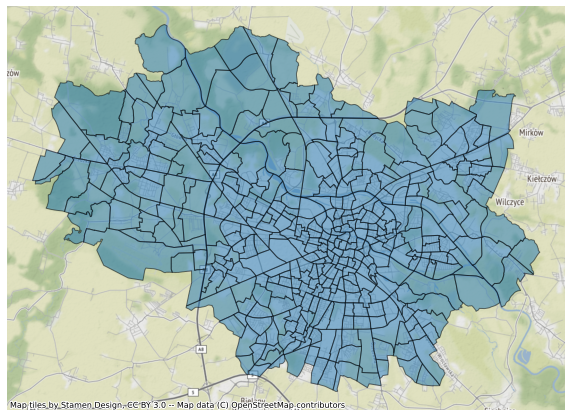

In [60]:
ax = regions.plot(figsize=(10,10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)
ax.set_axis_off()